# # EE4375: Seventh Lab Session: Two Dimensional Finite Element Simulation of an Inductor

The **goals** of this seventh lab session is to apply the two-dimensional finite element to the computation of the magnetic field caused by the curent flowing through the coil of wounded around the middle leg of a three-legged inductor. 

The lab session goes through the **five steps** typical of a finite element solution procedure. In the **first** step, the geometry of the configuration is generated. Here we consider the cross-section the ferromagnetic core with the multi-turn coil encircling the middle core leg. The geometry thus consists of three subdomain. The first subdomain in the ferromagnetic core subdomain. The second subdomain is the air subdomain. The third subdomain is the third subdomain. This latter subdomain is subdivided in two parts, each corresponding to a direction of the applied current density. The mesh is generated using geometry primitives that GMSH provided. In the **second** step, the mesh is generated using the geometry as input. The mesh is generated using a a variant of the Delaunay method. In this method the interior and exterior boundaries of the geometries are meshes first. The boundary mesh is subsequently advanced into the interior of the domain. In the **third** step, the physics consisting of the partial differential equation and boundary conditions in imposed on the mesh. Here we impose the physics of a perpendicular current generating a magnetic field. The z-component of the magnetic vector potential is solved for. In the **fourth** step, the discrete linear problem is assembled by a loop over the elements and solved by a sparse direct solver. First order linear Lagrange shape functions on an unstructured mesh of triangular elements is employed. In the **fifth** and final step, the computed solution is written to a VTK file allowing visualization using e.g. Paraview. 

## Import Packages

In [1]:
import Gmsh: gmsh 
using GR 
using GRUtils
using LinearAlgebra
using Plots
using LaTeXStrings

Exercise: 

Study the code that follows.

## Geometry Definition 

In [2]:
gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 1)
#..define the model
model = gmsh.model
model.add("Transformer")
#..define mesh density near a point
lg = 0.7    #gap length in mm
lg = 5    #gap length in mm
mur = 2000;  #relative permeability of the core
mu0 = 4*pi*10^(-7);
curr_dens_value = 3.1085;
k = 0.2227
cl = 5     #mesh size at bounday
c2 = lg/2  #mesh size at airgap
c3 = 2     #mesh size at component
#..define four points in the geometry
gmsh.model.geo.addPoint(50, 50, 0., cl, 1)
gmsh.model.geo.addPoint(-50, 50, 0., cl, 2)
gmsh.model.geo.addPoint(-50, -50,0., cl, 3)
gmsh.model.geo.addPoint(50, -50, 0., cl, 4)
#..upper half of core
gmsh.model.geo.addPoint(-27.25, lg/2, 0., c2, 5)
gmsh.model.geo.addPoint(-27.25, 27.6+lg/2, 0., c3, 6)
gmsh.model.geo.addPoint(27.25, 27.6+lg/2, 0., c3, 7)
gmsh.model.geo.addPoint(27.25, lg/2, 0., c2, 8)
gmsh.model.geo.addPoint(20.6, lg/2, 0., c2, 9)
gmsh.model.geo.addPoint(20.6, 20.2+lg/2, 0., c3, 10)
gmsh.model.geo.addPoint(7.422, 20.2+lg/2, 0., c3, 11)
gmsh.model.geo.addPoint(7.422, lg/2, 0., c2, 12)
gmsh.model.geo.addPoint(-7.422, lg/2, 0., c2, 13)
gmsh.model.geo.addPoint(-7.422, 20.2+lg/2, 0., c3, 14)
gmsh.model.geo.addPoint(-20.6, 20.2+lg/2, 0., c3, 15)
gmsh.model.geo.addPoint(-20.6, lg/2, 0., c2, 16)
#..lower half of core
gmsh.model.geo.addPoint(-27.25, -lg/2, 0., c2, 17)
gmsh.model.geo.addPoint(-27.25, -27.6-lg/2, 0., c3, 18)
gmsh.model.geo.addPoint(27.25, -27.6-lg/2, 0., c3, 19)
gmsh.model.geo.addPoint(27.25, -lg/2, 0., c2, 20)
gmsh.model.geo.addPoint(20.6, -lg/2, 0., c2, 21)
gmsh.model.geo.addPoint(20.6, -20.2-lg/2, 0., c3, 22)
gmsh.model.geo.addPoint(7.422, -20.2-lg/2, 0., c3, 23)
gmsh.model.geo.addPoint(7.422, -lg/2, 0., c2, 24)
gmsh.model.geo.addPoint(-7.422, -lg/2, 0., c2, 25)
gmsh.model.geo.addPoint(-7.422, -20.2-lg/2, 0., c3, 26)
gmsh.model.geo.addPoint(-20.6, -20.2-lg/2, 0., c3, 27)
gmsh.model.geo.addPoint(-20.6, -lg/2, 0., c2, 28)
#..define four edges in the geometry
gmsh.model.geo.addLine(1, 2, 101)
gmsh.model.geo.addLine(2, 3, 102)
gmsh.model.geo.addLine(3, 4, 103)
gmsh.model.geo.addLine(4, 1, 104)
#..upper half of core
gmsh.model.geo.addLine(5, 6, 105)
gmsh.model.geo.addLine(6, 7, 106)
gmsh.model.geo.addLine(7, 8, 107)
gmsh.model.geo.addLine(8, 9, 108)
gmsh.model.geo.addLine(9, 10, 109)
gmsh.model.geo.addLine(10, 11, 110)
gmsh.model.geo.addLine(11, 12, 111)
gmsh.model.geo.addLine(12, 13, 112)
gmsh.model.geo.addLine(13, 14, 113)
gmsh.model.geo.addLine(14, 15, 114)
gmsh.model.geo.addLine(15, 16, 115)
gmsh.model.geo.addLine(16, 5, 116)
#..lower half of core
gmsh.model.geo.addLine(18, 17, 117)
gmsh.model.geo.addLine(19, 18, 118)
gmsh.model.geo.addLine(20, 19, 119)
gmsh.model.geo.addLine(21, 20, 120)
gmsh.model.geo.addLine(22, 21, 121)
gmsh.model.geo.addLine(23, 22, 122)
gmsh.model.geo.addLine(24, 23, 123)
gmsh.model.geo.addLine(25, 24, 124)
gmsh.model.geo.addLine(26, 25, 125)
gmsh.model.geo.addLine(27, 26, 126)
gmsh.model.geo.addLine(28, 27, 127)
gmsh.model.geo.addLine(17, 28, 128)
# close off winding slots (right to left)
gmsh.model.geo.addLine(21, 9, 129)
gmsh.model.geo.addLine(12, 24, 130)
gmsh.model.geo.addLine(25, 13, 131)
gmsh.model.geo.addLine(16, 28, 132)
# link core area to outside
gmsh.model.geo.addLine(2, 6, 133)
gmsh.model.geo.addLine(19, 4, 134)
gmsh.model.geo.addLine(9, 21, 135)
gmsh.model.geo.addLine(6, 2, 136)
gmsh.model.geo.addLine(4, 19, 137)
gmsh.model.geo.addLine(28,16, 138)
# redefine air gap lines for middle gap
gmsh.model.geo.addLine(24, 12, 139)
gmsh.model.geo.addLine(13, 25, 140)
#..define outer boundary
gmsh.model.geo.addCurveLoop([101, 133, 106, 107, 108, 135, 120, 119, 134, 104], 201) # air 1
gmsh.model.geo.addCurveLoop([102, 103, 137, 118, 117, 128, 138, 116, 105, 136], 202) # air 2
gmsh.model.geo.addCurveLoop([105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116], 203) # upper core
gmsh.model.geo.addCurveLoop([117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128], 204) # lower core
gmsh.model.geo.addCurveLoop([109, 110, 111, 130, 123, 122 , 121, 129], 205) # right winding gap
gmsh.model.geo.addCurveLoop([113, 114, 115, 131, 125, 126 ,127, 132], 206) # left winding gap
gmsh.model.geo.addCurveLoop([112, 140, 124, 139], 207) # middle air gap
#..define planar surface
gmsh.model.geo.addPlaneSurface([201], 301)
gmsh.model.geo.addPlaneSurface([202], 302)
gmsh.model.geo.addPlaneSurface([203], 303)
gmsh.model.geo.addPlaneSurface([204], 304)
gmsh.model.geo.addPlaneSurface([205], 305)
gmsh.model.geo.addPlaneSurface([206], 306)
gmsh.model.geo.addPlaneSurface([207], 307)
#..define physics
gmsh.model.addPhysicalGroup(2,[301; 302; 307],401)
gmsh.model.addPhysicalGroup(2,[303],402)
gmsh.model.addPhysicalGroup(2,[304],403)
gmsh.model.addPhysicalGroup(2,[305],404)
gmsh.model.addPhysicalGroup(2,[306],405)
#..generate the mesh in 2D
gmsh.model.geo.synchronize()
model.mesh.generate(2)
#..save the mesh to file for future reference
#gmsh.write("transformer.msh")

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 101 (Line)
Info    : [ 10%] Meshing curve 102 (Line)
Info    : [ 10%] Meshing curve 103 (Line)
Info    : [ 10%] Meshing curve 104 (Line)
Info    : [ 10%] Meshing curve 105 (Line)
Info    : [ 20%] Meshing curve 106 (Line)
Info    : [ 20%] Meshing curve 107 (Line)
Info    : [ 20%] Meshing curve 108 (Line)
Info    : [ 20%] Meshing curve 109 (Line)
Info    : [ 30%] Meshing curve 110 (Line)
Info    : [ 30%] Meshing curve 111 (Line)
Info    : [ 30%] Meshing curve 112 (Line)
Info    : [ 30%] Meshing curve 113 (Line)
Info    : [ 40%] Meshing curve 114 (Line)
Info    : [ 40%] Meshing curve 115 (Line)
Info    : [ 40%] Meshing curve 116 (Line)
Info    : [ 40%] Meshing curve 117 (Line)
Info    : [ 50%] Meshing curve 118 (Line)
Info    : [ 50%] Meshing curve 119 (Line)
Info    : [ 50%] Meshing curve 120 (Line)
Info    : [ 50%] Meshing curve 121 (Line)
Info    : [ 60%] Meshing curve 122 (Line)
Info    : [ 60%] Meshing curve 123 (Line)
Info    : 

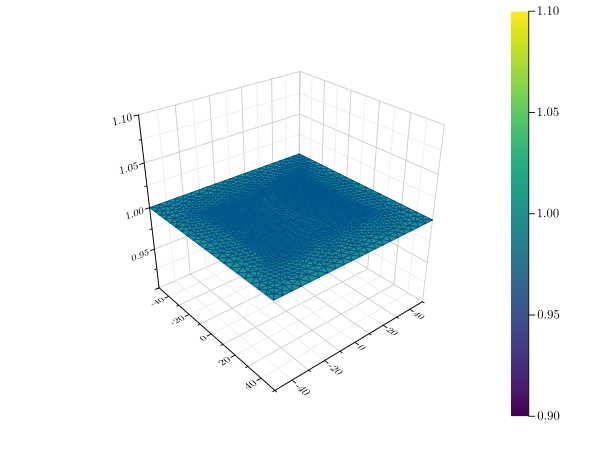

In [3]:
#..2/11 Get and sort the mesh nodes
#..Observe that although the mesh is two-dimensional,
#..the z-coordinate that is equal to zero is stored as well.
#..Observe that the coordinates are stored contiguously for computational
#..efficiency
node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
nnodes = length(node_ids)
#..sort the node coordinates by ID, such that Node one sits at row 1
tosort = [node_ids node_coord[1:3:end] node_coord[2:3:end]];
sorted = sortslices(tosort , dims = 1);
node_ids = sorted[:,1]
xnode = sorted[:,2]
ynode = sorted[:,3]

#..3/11 Plotting the mesh
z = ones(length(xnode))
GR.trisurf(xnode,ynode,z)

GKS: Viewport is not within the NDC unit square in routine SET_VIEWPORT


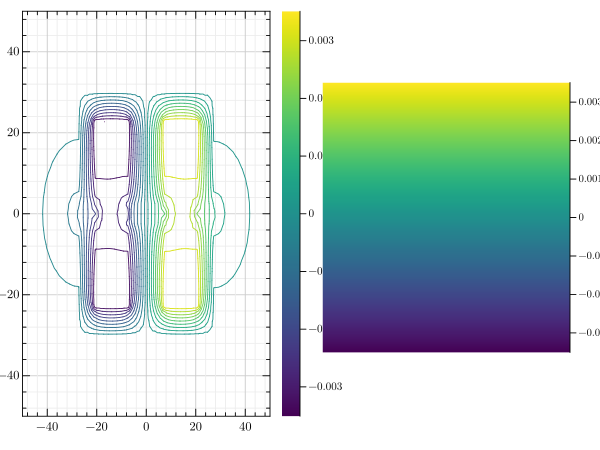

In [4]:
#..4/12 Get the mesh elements
#..observe that we get all the two-dimensional triangular elements from the mesh
element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(2)
nelements = length(element_ids[1])

#..5/12 Create groups of elements for the subdomains
#..for loop that creates a vector describing which physical group an element belongs to
ngroup1 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 401)
ngroup2 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 402)
ngroup3 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 403)
ngroup4 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 404)
ngroup5 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 405)
e_group = zeros(1,nelements)
for element_id in 1:nelements
  node1_id = element_connectivity[1][3*(element_id-1)+1]
  node2_id = element_connectivity[1][3*(element_id-1)+2]
  node3_id = element_connectivity[1][3*(element_id-1)+3]
  G1 = sum(node1_id.== ngroup1[1])+sum(node2_id.== ngroup1[1])+sum(node3_id.== ngroup1[1]) #Air
  G2 = sum(node1_id.== ngroup2[1])+sum(node2_id.== ngroup2[1])+sum(node3_id.== ngroup2[1]) #upper core
  G3 = sum(node1_id.== ngroup3[1])+sum(node2_id.== ngroup3[1])+sum(node3_id.== ngroup3[1]) #lower core
  G4 = sum(node1_id.== ngroup4[1])+sum(node2_id.== ngroup4[1])+sum(node3_id.== ngroup4[1]) #winding right
  G5 = sum(node1_id.== ngroup5[1])+sum(node2_id.== ngroup5[1])+sum(node3_id.== ngroup5[1]) #winding left
  if G1 == 3
    e_group[element_id] = 1;
  elseif G2 == 3 || G3 == 3
    e_group[element_id] = 2;
  elseif G4 == 3
    e_group[element_id] = 4;
  elseif G5 == 3
    e_group[element_id] = 5;
  end
  if (false)
    println("on element ", element_id, " e_group[element_id] = ", e_group[element_id])
  end
end

#..6/12 Define the source function and the reluctivity function and
#..define the source function and reluctivity value for each element in the mesh using map.
#..Observe that, unlike before, both the source function and the reluctivity function are defined
#..as constant values per element (instead of constant per node).
#..The source function defines the current density value in the left and right side of the winding.
sourcefunction(group_id) = curr_dens_value*(group_id==4)-curr_dens_value*(group_id==5)
sourceperelement = map(sourcefunction, e_group)
#..The reluctivity function defines the reluctivity value over the whole domain
#..The reluctivity is set equal to nu0 = 1/mu0 in the coil and air subdomains
#..The reluctivity is set equal to nu=1/mu=1/(mu0*muR) in the ferromagnetic core subdomains
reluctivityfunction(group_id) = (1/mu0)*((group_id==1)+(group_id==4)+(group_id==5))+(1/(mu0*mur))*((group_id==2)+mur*(group_id==3))
reluctivityperelement = map(reluctivityfunction, e_group)

#..7/12 initialize global matrix A and global vector f
#..observe that for simplicity we use dense matrix here
A = zeros(nnodes,nnodes)
f = zeros(nnodes,1)

#..8/12 Perform a loop over the elements
for element_id in 1:nelements

  #....retrieve global numbering of the local nodes of the current element
  node1_id = element_connectivity[1][3*(element_id-1)+1]
  node2_id = element_connectivity[1][3*(element_id-1)+2]
  node3_id = element_connectivity[1][3*(element_id-1)+3]

  #....retrieve the x and y coordinates of the local nodes of the current element
  xnode1 = xnode[node1_id]; xnode2 = xnode[node2_id]; xnode3 = xnode[node3_id];
  ynode1 = ynode[node1_id]; ynode2 = ynode[node2_id]; ynode3 = ynode[node3_id];

  #....compute surface area of the current element
  x12 = xnode2 - xnode1; x13 = xnode3-xnode1;
  y12 = ynode2 - ynode1; y13 = ynode3-ynode1;
  area_id = x12*y13 - x13*y12; area_id = abs(area_id)/2

  #....if desired, print global number numbers and element area to screen
  if (false)
    println("on element ", element_id, " node-1 has global number ", node1_id)
    println("on element ", element_id, " node-2 has global number ", node2_id)
    println("on element ", element_id, " node-3 has global number ", node3_id)
    println("on element ", element_id, " area = ", area_id)
    println(" ")
  end

  #....compute local vector contribution floc of the current element
  floc = area_id/3*sourceperelement[element_id]*[1; 1; 1]

  #....compute local matrix contribution Aloc of the current element
  Emat = [[xnode1;xnode2;xnode3] [ynode1;ynode2;ynode3] [1;1;1]]\UniformScaling(1.);
  Emat[3,:] .= 0;
  Aloc = area_id*reluctivityperelement[element_id]*(transpose(Emat)*Emat);

  #....perform loop over nodes of the current element
  #....and add local contribution Aloc to global matrix entity A
  for i = 1:3
    I = element_connectivity[1][3*(element_id-1)+i]
    f[I] += floc[i]
    for j = 1:3
      J = element_connectivity[1][3*(element_id-1)+j]
      A[I,J] += Aloc[i,j]
    end
  end

end

#..9/12 Handle the boundary conditions
#..retrieve boundary nodes by loop over corner point and boundary edges
node_ids1, node_coord, _ = gmsh.model.mesh.getNodes(0,1)
node_ids2, node_coord, _ = gmsh.model.mesh.getNodes(0,2)
node_ids3, node_coord, _ = gmsh.model.mesh.getNodes(0,3)
node_ids4, node_coord, _ = gmsh.model.mesh.getNodes(0,4)
node_ids5, node_coord, _ = gmsh.model.mesh.getNodes(1,101)
node_ids6, node_coord, _ = gmsh.model.mesh.getNodes(1,102)
node_ids7, node_coord, _ = gmsh.model.mesh.getNodes(1,103)
node_ids8, node_coord, _ = gmsh.model.mesh.getNodes(1,104)
bnd_node_ids = union(node_ids1,node_ids2,node_ids3,node_ids4,node_ids5,node_ids6,node_ids7,node_ids8)
A[bnd_node_ids,:] .= 0;
A[bnd_node_ids,bnd_node_ids] = Diagonal(ones(size(bnd_node_ids)))
f[bnd_node_ids] .= 0;

#..10/12 Compute the numerical solution
u = A\f

#..11/12 Plot the numerical solution and perform post-processing
Bav = (maximum(u)-minimum(u))/(2*7.422*0.001) # estimate the core flux desnity
if (false)
  println("The estimated magnetic flux density in the core is equal to ", Bav, " T")
end
# tricont(xnode,ynode,u)
leftplot = GR.subplot(1,2,1)
p1 = GR.tricont(xnode,ynode,u)
rightplot = GR.subplot(1,2,2)
p2 = GR.trisurf(xnode,ynode,u)
#GR.plot(p1)
#Plots.plot(p1)

In [6]:
#..11/11 Finalize GMSH
gmsh.finalize()

In [11]:
#..solves the z-component of the magnetic vector potential for a transformer
#..the diffusion coefficient for the magnetic vector potential is the reluctivity
#..the reluctivity nu is defined as the reciprocal of the permeability mu, i.e., nu = 1/mu
#..the reluctivity if vacuum (air) is denoted as nu0 and is given by nu0 = 1/mu0 where mu0 = 4*pi*10^(-7)
#..the relative reluctivity is denoted as nuR and given by nuR = 1/muR

using Plots
using GR
# ]add https://github.com/koehlerson/gmsh.jl.git
import Gmsh: gmsh
using LinearAlgebra #..to define UniformScaling..

#..1/12 Define geometry and mesh. Save mesh to file.
gmsh.initialize(ARGS)
gmsh.option.setNumber("General.Terminal", 1)
#..define the model
model = gmsh.model
model.add("Transformer")
#..define mesh density near a point
lg = 0.7    #gap length in mm
lg = 5    #gap length in mm
mur = 2000;  #relative permeability of the core
mu0 = 4*pi*10^(-7);
curr_dens_value = 3.1085;
k = 0.2227
cl = 5     #mesh size at bounday
c2 = lg/2  #mesh size at airgap
c3 = 2     #mesh size at component
#..define four points in the geometry
gmsh.model.geo.addPoint(50, 50, 0., cl, 1)
gmsh.model.geo.addPoint(-50, 50, 0., cl, 2)
gmsh.model.geo.addPoint(-50, -50,0., cl, 3)
gmsh.model.geo.addPoint(50, -50, 0., cl, 4)
#..upper half of core
gmsh.model.geo.addPoint(-27.25, lg/2, 0., c2, 5)
gmsh.model.geo.addPoint(-27.25, 27.6+lg/2, 0., c3, 6)
gmsh.model.geo.addPoint(27.25, 27.6+lg/2, 0., c3, 7)
gmsh.model.geo.addPoint(27.25, lg/2, 0., c2, 8)
gmsh.model.geo.addPoint(20.6, lg/2, 0., c2, 9)
gmsh.model.geo.addPoint(20.6, 20.2+lg/2, 0., c3, 10)
gmsh.model.geo.addPoint(7.422, 20.2+lg/2, 0., c3, 11)
gmsh.model.geo.addPoint(7.422, lg/2, 0., c2, 12)
gmsh.model.geo.addPoint(-7.422, lg/2, 0., c2, 13)
gmsh.model.geo.addPoint(-7.422, 20.2+lg/2, 0., c3, 14)
gmsh.model.geo.addPoint(-20.6, 20.2+lg/2, 0., c3, 15)
gmsh.model.geo.addPoint(-20.6, lg/2, 0., c2, 16)
#..lower half of core
gmsh.model.geo.addPoint(-27.25, -lg/2, 0., c2, 17)
gmsh.model.geo.addPoint(-27.25, -27.6-lg/2, 0., c3, 18)
gmsh.model.geo.addPoint(27.25, -27.6-lg/2, 0., c3, 19)
gmsh.model.geo.addPoint(27.25, -lg/2, 0., c2, 20)
gmsh.model.geo.addPoint(20.6, -lg/2, 0., c2, 21)
gmsh.model.geo.addPoint(20.6, -20.2-lg/2, 0., c3, 22)
gmsh.model.geo.addPoint(7.422, -20.2-lg/2, 0., c3, 23)
gmsh.model.geo.addPoint(7.422, -lg/2, 0., c2, 24)
gmsh.model.geo.addPoint(-7.422, -lg/2, 0., c2, 25)
gmsh.model.geo.addPoint(-7.422, -20.2-lg/2, 0., c3, 26)
gmsh.model.geo.addPoint(-20.6, -20.2-lg/2, 0., c3, 27)
gmsh.model.geo.addPoint(-20.6, -lg/2, 0., c2, 28)
#..define four edges in the geometry
gmsh.model.geo.addLine(1, 2, 101)
gmsh.model.geo.addLine(2, 3, 102)
gmsh.model.geo.addLine(3, 4, 103)
gmsh.model.geo.addLine(4, 1, 104)
#..upper half of core
gmsh.model.geo.addLine(5, 6, 105)
gmsh.model.geo.addLine(6, 7, 106)
gmsh.model.geo.addLine(7, 8, 107)
gmsh.model.geo.addLine(8, 9, 108)
gmsh.model.geo.addLine(9, 10, 109)
gmsh.model.geo.addLine(10, 11, 110)
gmsh.model.geo.addLine(11, 12, 111)
gmsh.model.geo.addLine(12, 13, 112)
gmsh.model.geo.addLine(13, 14, 113)
gmsh.model.geo.addLine(14, 15, 114)
gmsh.model.geo.addLine(15, 16, 115)
gmsh.model.geo.addLine(16, 5, 116)
#..lower half of core
gmsh.model.geo.addLine(18, 17, 117)
gmsh.model.geo.addLine(19, 18, 118)
gmsh.model.geo.addLine(20, 19, 119)
gmsh.model.geo.addLine(21, 20, 120)
gmsh.model.geo.addLine(22, 21, 121)
gmsh.model.geo.addLine(23, 22, 122)
gmsh.model.geo.addLine(24, 23, 123)
gmsh.model.geo.addLine(25, 24, 124)
gmsh.model.geo.addLine(26, 25, 125)
gmsh.model.geo.addLine(27, 26, 126)
gmsh.model.geo.addLine(28, 27, 127)
gmsh.model.geo.addLine(17, 28, 128)
# close off winding slots (right to left)
gmsh.model.geo.addLine(21, 9, 129)
gmsh.model.geo.addLine(12, 24, 130)
gmsh.model.geo.addLine(25, 13, 131)
gmsh.model.geo.addLine(16, 28, 132)
# link core area to outside
gmsh.model.geo.addLine(2, 6, 133)
gmsh.model.geo.addLine(19, 4, 134)
gmsh.model.geo.addLine(9, 21, 135)
gmsh.model.geo.addLine(6, 2, 136)
gmsh.model.geo.addLine(4, 19, 137)
gmsh.model.geo.addLine(28,16, 138)
# redefine air gap lines for middle gap
gmsh.model.geo.addLine(24, 12, 139)
gmsh.model.geo.addLine(13, 25, 140)
#..define outer boundary
gmsh.model.geo.addCurveLoop([101, 133, 106, 107, 108, 135, 120, 119, 134, 104], 201) # air 1
gmsh.model.geo.addCurveLoop([102, 103, 137, 118, 117, 128, 138, 116, 105, 136], 202) # air 2
gmsh.model.geo.addCurveLoop([105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116], 203) # upper core
gmsh.model.geo.addCurveLoop([117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128], 204) # lower core
gmsh.model.geo.addCurveLoop([109, 110, 111, 130, 123, 122 , 121, 129], 205) # right winding gap
gmsh.model.geo.addCurveLoop([113, 114, 115, 131, 125, 126 ,127, 132], 206) # left winding gap
gmsh.model.geo.addCurveLoop([112, 140, 124, 139], 207) # middle air gap
#..define planar surface
gmsh.model.geo.addPlaneSurface([201], 301)
gmsh.model.geo.addPlaneSurface([202], 302)
gmsh.model.geo.addPlaneSurface([203], 303)
gmsh.model.geo.addPlaneSurface([204], 304)
gmsh.model.geo.addPlaneSurface([205], 305)
gmsh.model.geo.addPlaneSurface([206], 306)
gmsh.model.geo.addPlaneSurface([207], 307)
#..define physics
gmsh.model.addPhysicalGroup(2,[301; 302; 307],401)
gmsh.model.addPhysicalGroup(2,[303],402)
gmsh.model.addPhysicalGroup(2,[304],403)
gmsh.model.addPhysicalGroup(2,[305],404)
gmsh.model.addPhysicalGroup(2,[306],405)
#..generte the mesh in 2D
gmsh.model.geo.synchronize()
model.mesh.generate(2)
#..save the mesh to file for future reference
gmsh.write("transformer.msh")

#..2/12 Get and sort the mesh nodes
#..Observe that although the mesh is two-dimensional,
#..the z-coordinate that is equal to zero is stored as well.
#..Observe that the coordinates are stored contiguously for computational
#..efficiency
node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
nnodes = length(node_ids)
#..sort the node coordinates by ID, such that Node one sits at row 1
tosort = [node_ids node_coord[1:3:end] node_coord[2:3:end]];
sorted = sortslices(tosort , dims = 1);
node_ids = sorted[:,1]
xnode = sorted[:,2]
ynode = sorted[:,3]

#..3/12 Plotting the mesh
#..for later: print mesh as VTK file and view using ParaView
#..(as documented under VTK.jl and as for instance GridApp.jl does)
z = ones(length(xnode))
GR.trisurf(xnode,ynode,z)

#..4/12 Get the mesh elements
#..observe that we get all the two-dimensional triangular elements from the mesh
element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(2)
nelements = length(element_ids[1])

#..5/12 Create groups of elements for the subdomains
#..for loop that creates a vector describing which physical group an element belongs to
ngroup1 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 401)
ngroup2 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 402)
ngroup3 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 403)
ngroup4 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 404)
ngroup5 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 405)
e_group = zeros(1,nelements)
for element_id in 1:nelements
  node1_id = element_connectivity[1][3*(element_id-1)+1]
  node2_id = element_connectivity[1][3*(element_id-1)+2]
  node3_id = element_connectivity[1][3*(element_id-1)+3]
  G1 = sum(node1_id.== ngroup1[1])+sum(node2_id.== ngroup1[1])+sum(node3_id.== ngroup1[1]) #Air
  G2 = sum(node1_id.== ngroup2[1])+sum(node2_id.== ngroup2[1])+sum(node3_id.== ngroup2[1]) #upper core
  G3 = sum(node1_id.== ngroup3[1])+sum(node2_id.== ngroup3[1])+sum(node3_id.== ngroup3[1]) #lower core
  G4 = sum(node1_id.== ngroup4[1])+sum(node2_id.== ngroup4[1])+sum(node3_id.== ngroup4[1]) #winding right
  G5 = sum(node1_id.== ngroup5[1])+sum(node2_id.== ngroup5[1])+sum(node3_id.== ngroup5[1]) #winding left
  if G1 == 3
    e_group[element_id] = 1;
  elseif G2 == 3 || G3 == 3
    e_group[element_id] = 2;
  elseif G4 == 3
    e_group[element_id] = 4;
  elseif G5 == 3
    e_group[element_id] = 5;
  end
  if (true)
    println("on element ", element_id, " e_group[element_id] = ", e_group[element_id])
  end
end

#..6/12 Define the source function and the reluctivity function and
#..define the source function and reluctivity value for each element in the mesh using map.
#..Observe that, unlike before, both the source function and the reluctivity function are defined
#..as constant values per element (instead of constant per node).
#..The source function defines the current density value in the left and right side of the winding.
sourcefunction(group_id) = curr_dens_value*(group_id==4)-curr_dens_value*(group_id==5)
sourceperelement = map(sourcefunction, e_group)
#..The reluctivity function defines the reluctivity value over the whole domain
#..The reluctivity is set equal to nu0 = 1/mu0 in the coil and air subdomains
#..The reluctivity is set equal to nu=1/mu=1/(mu0*muR) in the ferromagnetic core subdomains
reluctivityfunction(group_id) = (1/mu0)*((group_id==1)+(group_id==4)+(group_id==5))+(1/(mu0*mur))*((group_id==2)+mur*(group_id==3))
reluctivityperelement = map(reluctivityfunction, e_group)

#..7/12 initialize global matrix A and global vector f
#..observe that for simplicity we use dense matrix here
A = zeros(nnodes,nnodes)
f = zeros(nnodes,1)

#..8/12 Perform a loop over the elements
for element_id in 1:nelements

  #....retrieve global numbering of the local nodes of the current element
  node1_id = element_connectivity[1][3*(element_id-1)+1]
  node2_id = element_connectivity[1][3*(element_id-1)+2]
  node3_id = element_connectivity[1][3*(element_id-1)+3]

  #....retrieve the x and y coordinates of the local nodes of the current element
  xnode1 = xnode[node1_id]; xnode2 = xnode[node2_id]; xnode3 = xnode[node3_id];
  ynode1 = ynode[node1_id]; ynode2 = ynode[node2_id]; ynode3 = ynode[node3_id];

  #....compute surface area of the current element
  x12 = xnode2 - xnode1; x13 = xnode3-xnode1;
  y12 = ynode2 - ynode1; y13 = ynode3-ynode1;
  area_id = x12*y13 - x13*y12; area_id = abs(area_id)/2

  #....if desired, print global number numbers and element area to screen
  if (false)
    println("on element ", element_id, " node-1 has global number ", node1_id)
    println("on element ", element_id, " node-2 has global number ", node2_id)
    println("on element ", element_id, " node-3 has global number ", node3_id)
    println("on element ", element_id, " area = ", area_id)
    println(" ")
  end

  #....compute local vector contribution floc of the current element
  floc = area_id/3*sourceperelement[element_id]*[1; 1; 1]

  #....compute local matrix contribution Aloc of the current element
  Emat = [[xnode1;xnode2;xnode3] [ynode1;ynode2;ynode3] [1;1;1]]\UniformScaling(1.);
  Emat[3,:] .= 0;
  Aloc = area_id*reluctivityperelement[element_id]*(transpose(Emat)*Emat);

  #....perform loop over nodes of the current element
  #....and add local contribution Aloc to global matrix entity A
  for i = 1:3
    I = element_connectivity[1][3*(element_id-1)+i]
    f[I] += floc[i]
    for j = 1:3
      J = element_connectivity[1][3*(element_id-1)+j]
      A[I,J] += Aloc[i,j]
    end
  end

end

#..9/12 Handle the boundary conditions
#..retrieve boundary nodes by loop over corner point and boundary edges
node_ids1, node_coord, _ = gmsh.model.mesh.getNodes(0,1)
node_ids2, node_coord, _ = gmsh.model.mesh.getNodes(0,2)
node_ids3, node_coord, _ = gmsh.model.mesh.getNodes(0,3)
node_ids4, node_coord, _ = gmsh.model.mesh.getNodes(0,4)
node_ids5, node_coord, _ = gmsh.model.mesh.getNodes(1,101)
node_ids6, node_coord, _ = gmsh.model.mesh.getNodes(1,102)
node_ids7, node_coord, _ = gmsh.model.mesh.getNodes(1,103)
node_ids8, node_coord, _ = gmsh.model.mesh.getNodes(1,104)
bnd_node_ids = union(node_ids1,node_ids2,node_ids3,node_ids4,node_ids5,node_ids6,node_ids7,node_ids8)
A[bnd_node_ids,:] .= 0;
A[bnd_node_ids,bnd_node_ids] = Diagonal(ones(size(bnd_node_ids)))
f[bnd_node_ids] .= 0;

#..10/12 Compute the numerical solution
u = A\f

#..11/12 Plot the numerical solution and perform post-processing
Bav = (maximum(u)-minimum(u))/(2*7.422*0.001) # estimate the core flux desnity
if (false)
  println("The estimated magnetic flux density in the core is equal to ", Bav, " T")
end
# tricont(xnode,ynode,u)
GR.tricont(xnode,ynode,u)

#..12/12 Finalize GMSH
gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 101 (Line)
Info    : [ 10%] Meshing curve 102 (Line)
Info    : [ 10%] Meshing curve 103 (Line)
Info    : [ 10%] Meshing curve 104 (Line)
Info    : [ 10%] Meshing curve 105 (Line)
Info    : [ 20%] Meshing curve 106 (Line)
Info    : [ 20%] Meshing curve 107 (Line)
Info    : [ 20%] Meshing curve 108 (Line)
Info    : [ 20%] Meshing curve 109 (Line)
Info    : [ 30%] Meshing curve 110 (Line)
Info    : [ 30%] Meshing curve 111 (Line)
Info    : [ 30%] Meshing curve 112 (Line)
Info    : [ 30%] Meshing curve 113 (Line)
Info    : [ 40%] Meshing curve 114 (Line)
Info    : [ 40%] Meshing curve 115 (Line)
Info    : [ 40%] Meshing curve 116 (Line)
Info    : [ 40%] Meshing curve 117 (Line)
Info    : [ 50%] Meshing curve 118 (Line)
Info    : [ 50%] Meshing curve 119 (Line)
Info    : [ 50%] Meshing curve 120 (Line)
Info    : [ 50%] Meshing curve 121 (Line)
Info    : [ 60%] Meshing curve 122 (Line)
Info    : [ 60%] Meshing curve 123 (Line)
Info    : 

on element 194 e_group[element_id] = 1.0
on element 195 e_group[element_id] = 1.0
on element 196 e_group[element_id] = 1.0
on element 197 e_group[element_id] = 1.0
on element 198 e_group[element_id] = 1.0
on element 199 e_group[element_id] = 1.0
on element 200 e_group[element_id] = 1.0
on element 201 e_group[element_id] = 1.0
on element 202 e_group[element_id] = 1.0
on element 203 e_group[element_id] = 1.0
on element 204 e_group[element_id] = 1.0
on element 205 e_group[element_id] = 1.0
on element 206 e_group[element_id] = 1.0
on element 207 e_group[element_id] = 1.0
on element 

GKS: Viewport is not within the NDC unit square in routine SET_VIEWPORT


208 e_group[element_id] = 1.0
on element 209 e_group[element_id] = 1.0
on element 210 e_group[element_id] = 1.0
on element 211 e_group[element_id] = 1.0
on element 212 e_group[element_id] = 1.0
on element 213 e_group[element_id] = 1.0
on element 214 e_group[element_id] = 1.0
on element 215 e_group[element_id] = 1.0
on element 216 e_group[element_id] = 1.0
on element 217 e_group[element_id] = 1.0
on element 218 e_group[element_id] = 1.0
on element 219 e_group[element_id] = 1.0
on element 220 e_group[element_id] = 1.0
on element 221 e_group[element_id] = 1.0
on element 222 e_group[element_id] = 1.0
on element 223 e_group[element_id] = 1.0
on element 224 e_group[element_id] = 1.0
on element 225 e_group[element_id] = 1.0
on element 226 e_group[element_id] = 1.0
on element 227 e_group[element_id] = 1.0
on element 228 e_group[element_id] = 1.0
on element 229 e_group[element_id] = 1.0
on element 230 e_group[element_id] = 1.0
on element 231 e_group[element_id] = 1.0
on element 232 e_group[elem

on element 458 e_group[element_id] = 1.0
on element 459 e_group[element_id] = 1.0
on element 460 e_group[element_id] = 1.0
on element 461 e_group[element_id] = 1.0
on element 462 e_group[element_id] = 1.0
on element 463 e_group[element_id] = 1.0
on element 464 e_group[element_id] = 1.0
on element 465 e_group[element_id] = 1.0
on element 466 e_group[element_id] = 1.0
on element 467 e_group[element_id] = 1.0
on element 468 e_group[element_id] = 1.0
on element 469 e_group[element_id] = 1.0
on element 470 e_group[element_id] = 1.0
on element 471 e_group[element_id] = 1.0
on element 472 e_group[element_id] = 1.0
on element 473 e_group[element_id] = 1.0
on element 474 e_group[element_id] = 1.0
on element 475 e_group[element_id] = 1.0
on element 476 e_group[element_id] = 1.0
on element 477 e_group[element_id] = 1.0
on element 478 e_group[element_id] = 1.0
on element 479 e_group[element_id] = 1.0
on element 480 e_group[element_id] = 1.0
on element 481 e_group[element_id] = 1.0
on element 482 e

on element 708 e_group[element_id] = 1.0
on element 709 e_group[element_id] = 1.0
on element 710 e_group[element_id] = 1.0
on element 711 e_group[element_id] = 1.0
on element 712 e_group[element_id] = 1.0
on element 713 e_group[element_id] = 1.0
on element 714 e_group[element_id] = 1.0
on element 715 e_group[element_id] = 1.0
on element 716 e_group[element_id] = 1.0
on element 717 e_group[element_id] = 1.0
on element 718 e_group[element_id] = 1.0
on element 719 e_group[element_id] = 1.0
on element 720 e_group[element_id] = 1.0
on element 721 e_group[element_id] = 1.0
on element 722 e_group[element_id] = 1.0
on element 723 e_group[element_id] = 1.0
on element 724 e_group[element_id] = 1.0
on element 725 e_group[element_id] = 1.0
on element 726 e_group[element_id] = 1.0
on element 727 e_group[element_id] = 1.0
on element 728 e_group[element_id] = 1.0
on element 729 e_group[element_id] = 1.0
on element 730 e_group[element_id] = 1.0
on element 731 e_group[element_id] = 1.0
on element 732 e

on element 958 e_group[element_id] = 1.0
on element 959 e_group[element_id] = 1.0
on element 960 e_group[element_id] = 1.0
on element 961 e_group[element_id] = 1.0
on element 962 e_group[element_id] = 1.0
on element 963 e_group[element_id] = 1.0
on element 964 e_group[element_id] = 1.0
on element 965 e_group[element_id] = 1.0
on element 966 e_group[element_id] = 1.0
on element 967 e_group[element_id] = 1.0
on element 968 e_group[element_id] = 1.0
on element 969 e_group[element_id] = 1.0
on element 970 e_group[element_id] = 1.0
on element 971 e_group[element_id] = 1.0
on element 972 e_group[element_id] = 1.0
on element 973 e_group[element_id] = 1.0
on element 974 e_group[element_id] = 1.0
on element 975 e_group[element_id] = 1.0
on element 976 e_group[element_id] = 1.0
on element 977 e_group[element_id] = 1.0
on element 978 e_group[element_id] = 1.0
on element 979 e_group[element_id] = 1.0
on element 980 e_group[element_id] = 1.0
on element 981 e_group[element_id] = 1.0
on element 982 e

on element 1279 e_group[element_id] = 1.0
on element 1280 e_group[element_id] = 1.0
on element 1281 e_group[element_id] = 1.0
on element 1282 e_group[element_id] = 1.0
on element 1283 e_group[element_id] = 1.0
on element 1284 e_group[element_id] = 1.0
on element 1285 e_group[element_id] = 1.0
on element 1286 e_group[element_id] = 1.0
on element 1287 e_group[element_id] = 1.0
on element 1288 e_group[element_id] = 1.0
on element 1289 e_group[element_id] = 1.0
on element 1290 e_group[element_id] = 1.0
on element 1291 e_group[element_id] = 1.0
on element 1292 e_group[element_id] = 1.0
on element 1293 e_group[element_id] = 1.0
on element 1294 e_group[element_id] = 1.0
on element 1295 e_group[element_id] = 1.0
on element 1296 e_group[element_id] = 1.0
on element 1297 e_group[element_id] = 1.0
on element 1298 e_group[element_id] = 1.0
on element 1299 e_group[element_id] = 1.0
on element 1300 e_group[element_id] = 1.0
on element 1301 e_group[element_id] = 1.0
on element 1302 e_group[element_id

on element 1523 e_group[element_id] = 1.0
on element 1524 e_group[element_id] = 1.0
on element 1525 e_group[element_id] = 1.0
on element 1526 e_group[element_id] = 1.0
on element 1527 e_group[element_id] = 1.0
on element 1528 e_group[element_id] = 1.0
on element 1529 e_group[element_id] = 1.0
on element 1530 e_group[element_id] = 1.0
on element 1531 e_group[element_id] = 1.0
on element 1532 e_group[element_id] = 1.0
on element 1533 e_group[element_id] = 1.0
on element 1534 e_group[element_id] = 1.0
on element 1535 e_group[element_id] = 1.0
on element 1536 e_group[element_id] = 1.0
on element 1537 e_group[element_id] = 1.0
on element 1538 e_group[element_id] = 1.0
on element 1539 e_group[element_id] = 1.0
on element 1540 e_group[element_id] = 1.0
on element 1541 e_group[element_id] = 1.0
on element 1542 e_group[element_id] = 1.0
on element 1543 e_group[element_id] = 1.0
on element 1544 e_group[element_id] = 1.0
on element 1545 e_group[element_id] = 1.0
on element 1546 e_group[element_id

on element 1767 e_group[element_id] = 2.0
on element 1768 e_group[element_id] = 2.0
on element 1769 e_group[element_id] = 2.0
on element 1770 e_group[element_id] = 2.0
on element 1771 e_group[element_id] = 2.0
on element 1772 e_group[element_id] = 2.0
on element 1773 e_group[element_id] = 2.0
on element 1774 e_group[element_id] = 2.0
on element 1775 e_group[element_id] = 2.0
on element 1776 e_group[element_id] = 2.0
on element 1777 e_group[element_id] = 2.0
on element 1778 e_group[element_id] = 2.0
on element 1779 e_group[element_id] = 2.0
on element 1780 e_group[element_id] = 2.0
on element 1781 e_group[element_id] = 2.0
on element 1782 e_group[element_id] = 2.0
on element 1783 e_group[element_id] = 2.0
on element 1784 e_group[element_id] = 2.0
on element 1785 e_group[element_id] = 2.0
on element 1786 e_group[element_id] = 2.0
on element 1787 e_group[element_id] = 2.0
on element 1788 e_group[element_id] = 2.0
on element 1789 e_group[element_id] = 2.0
on element 1790 e_group[element_id

on element 2011 e_group[element_id] = 2.0
on element 2012 e_group[element_id] = 2.0
on element 2013 e_group[element_id] = 2.0
on element 2014 e_group[element_id] = 2.0
on element 2015 e_group[element_id] = 2.0
on element 2016 e_group[element_id] = 2.0
on element 2017 e_group[element_id] = 2.0
on element 2018 e_group[element_id] = 2.0
on element 2019 e_group[element_id] = 2.0
on element 2020 e_group[element_id] = 2.0
on element 2021 e_group[element_id] = 2.0
on element 2022 e_group[element_id] = 2.0
on element 2023 e_group[element_id] = 2.0
on element 2024 e_group[element_id] = 2.0
on element 2025 e_group[element_id] = 2.0
on element 2026 e_group[element_id] = 2.0
on element 2027 e_group[element_id] = 2.0
on element 2028 e_group[element_id] = 2.0
on element 2029 e_group[element_id] = 2.0
on element 2030 e_group[element_id] = 2.0
on element 2031 e_group[element_id] = 2.0
on element 2032 e_group[element_id] = 2.0
on element 2033 e_group[element_id] = 2.0
on element 2034 e_group[element_id

on element 2272 e_group[element_id] = 2.0
on element 2273 e_group[element_id] = 2.0
on element 2274 e_group[element_id] = 2.0
on element 2275 e_group[element_id] = 2.0
on element 2276 e_group[element_id] = 2.0
on element 2277 e_group[element_id] = 2.0
on element 2278 e_group[element_id] = 2.0
on element 2279 e_group[element_id] = 2.0
on element 2280 e_group[element_id] = 2.0
on element 2281 e_group[element_id] = 2.0
on element 2282 e_group[element_id] = 2.0
on element 2283 e_group[element_id] = 2.0
on element 2284 e_group[element_id] = 2.0
on element 2285 e_group[element_id] = 2.0
on element 2286 e_group[element_id] = 2.0
on element 2287 e_group[element_id] = 2.0
on element 2288 e_group[element_id] = 2.0
on element 2289 e_group[element_id] = 2.0
on element 2290 e_group[element_id] = 2.0
on element 2291 e_group[element_id] = 2.0
on element 2292 e_group[element_id] = 2.0
on element 2293 e_group[element_id] = 2.0
on element 2294 e_group[element_id] = 2.0
on element 2295 e_group[element_id

on element 2516 e_group[element_id] = 2.0
on element 2517 e_group[element_id] = 2.0
on element 2518 e_group[element_id] = 2.0
on element 2519 e_group[element_id] = 2.0
on element 2520 e_group[element_id] = 2.0
on element 2521 e_group[element_id] = 2.0
on element 2522 e_group[element_id] = 2.0
on element 2523 e_group[element_id] = 2.0
on element 2524 e_group[element_id] = 2.0
on element 2525 e_group[element_id] = 2.0
on element 2526 e_group[element_id] = 2.0
on element 2527 e_group[element_id] = 2.0
on element 2528 e_group[element_id] = 2.0
on element 2529 e_group[element_id] = 2.0
on element 2530 e_group[element_id] = 2.0
on element 2531 e_group[element_id] = 2.0
on element 2532 e_group[element_id] = 2.0
on element 2533 e_group[element_id] = 2.0
on element 2534 e_group[element_id] = 2.0
on element 2535 e_group[element_id] = 2.0
on element 2536 e_group[element_id] = 2.0
on element 2537 e_group[element_id] = 2.0
on element 2538 e_group[element_id] = 2.0
on element 2539 e_group[element_id

on element 2760 e_group[element_id] = 2.0
on element 2761 e_group[element_id] = 2.0
on element 2762 e_group[element_id] = 2.0
on element 2763 e_group[element_id] = 2.0
on element 2764 e_group[element_id] = 2.0
on element 2765 e_group[element_id] = 2.0
on element 2766 e_group[element_id] = 2.0
on element 2767 e_group[element_id] = 2.0
on element 2768 e_group[element_id] = 2.0
on element 2769 e_group[element_id] = 2.0
on element 2770 e_group[element_id] = 2.0
on element 2771 e_group[element_id] = 2.0
on element 2772 e_group[element_id] = 2.0
on element 2773 e_group[element_id] = 2.0
on element 2774 e_group[element_id] = 2.0
on element 2775 e_group[element_id] = 2.0
on element 2776 e_group[element_id] = 2.0
on element 2777 e_group[element_id] = 2.0
on element 2778 e_group[element_id] = 2.0
on element 2779 e_group[element_id] = 2.0
on element 2780 e_group[element_id] = 2.0
on element 2781 e_group[element_id] = 2.0
on element 2782 e_group[element_id] = 2.0
on element 2783 e_group[element_id

on element 3114 e_group[element_id] = 4.0
on element 3115 e_group[element_id] = 4.0
on element 3116 e_group[element_id] = 4.0
on element 3117 e_group[element_id] = 4.0
on element 3118 e_group[element_id] = 4.0
on element 3119 e_group[element_id] = 4.0
on element 3120 e_group[element_id] = 4.0
on element 3121 e_group[element_id] = 4.0
on element 3122 e_group[element_id] = 4.0
on element 3123 e_group[element_id] = 4.0
on element 3124 e_group[element_id] = 4.0
on element 3125 e_group[element_id] = 4.0
on element 3126 e_group[element_id] = 4.0
on element 3127 e_group[element_id] = 4.0
on element 3128 e_group[element_id] = 4.0
on element 3129 e_group[element_id] = 4.0
on element 3130 e_group[element_id] = 4.0
on element 3131 e_group[element_id] = 4.0
on element 3132 e_group[element_id] = 4.0
on element 3133 e_group[element_id] = 4.0
on element 3134 e_group[element_id] = 4.0
on element 3135 e_group[element_id] = 4.0
on element 3136 e_group[element_id] = 4.0
on element 3137 e_group[element_id

on element 3358 e_group[element_id] = 5.0
on element 3359 e_group[element_id] = 5.0
on element 3360 e_group[element_id] = 5.0
on element 3361 e_group[element_id] = 5.0
on element 3362 e_group[element_id] = 5.0
on element 3363 e_group[element_id] = 5.0
on element 3364 e_group[element_id] = 5.0
on element 3365 e_group[element_id] = 5.0
on element 3366 e_group[element_id] = 5.0
on element 3367 e_group[element_id] = 5.0
on element 3368 e_group[element_id] = 5.0
on element 3369 e_group[element_id] = 5.0
on element 3370 e_group[element_id] = 5.0
on element 3371 e_group[element_id] = 5.0
on element 3372 e_group[element_id] = 5.0
on element 3373 e_group[element_id] = 5.0
on element 3374 e_group[element_id] = 5.0
on element 3375 e_group[element_id] = 5.0
on element 3376 e_group[element_id] = 5.0
on element 3377 e_group[element_id] = 5.0
on element 3378 e_group[element_id] = 5.0
on element 3379 e_group[element_id] = 5.0
on element 3380 e_group[element_id] = 5.0
on element 3381 e_group[element_id

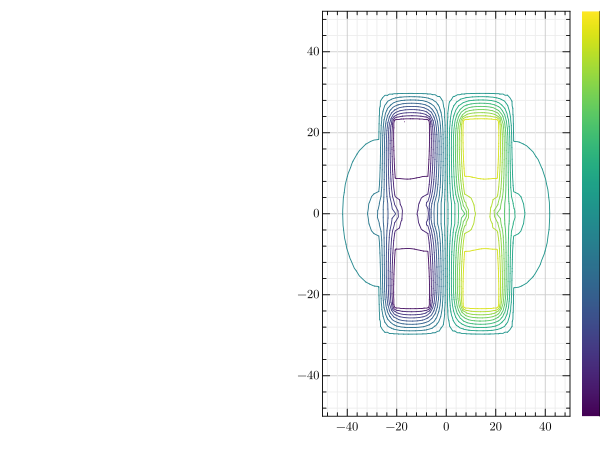

In [9]:
GR.tricont(xnode,ynode,u)

In [12]:
using DifferentialEquations

In [13]:
#..define the right-hand side of the ordinary differential equation of the equation of motion 
function scalarDiffusionEquation!(du,u,p,t)
    du .= M \ (f - A*u)
end

#..set initial position and velocity
u0 = fill(1.,nnodes)
                                    
#..set time begin and end forward
t0 = 0.0
tf = 2.0
tspan = (t0,tf)

#..define ODE problem to be solved  
prob_scalarDiffusion = ODEProblem(scalarDiffusionEquation!, u0, tspan)

#..solve ODE problem 
sol = DifferentialEquations.solve(prob_scalarDiffusion);

LoadError: UndefVarError: M not defined